In [ ]:
import os

import cv2
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [63]:
DATA_DIR = './Datasets/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

landmark_dataset = []
labels = []

# load options for hand landmark detection
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Group letters into classifications based on the number of fingers used
# 0 is for a closed fist
classifications = {
    'A': 0,
    'B': 0,
    'C': 0,
    'D': 1,
    'E': 0,
    'F': 3,
    'G': 2,
    'H': 0,
    'I': 1,
    'J': 1,
    'K': 2,
    'L': 2,
    'M': 0,
    'N': 0,
    'O': 0,
    'P': 2,
    'Q': 2,
    'R': 2,
    'S': 0,
    'T': 0,
    'U': 2,
    'V': 2,
    'W': 3,
    'X': 1,
    'Y': 2,
    'Z': 1,
}

total_images = 0
no_landmarks = 0

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='./Datasets/hand_landmarker.task'),
    running_mode=VisionRunningMode.IMAGE)
with HandLandmarker.create_from_options(options) as landmarker:
    for letter in os.listdir(DATA_DIR):
        if letter in ['del', 'nothing', 'space']:
            continue
        for i, img_path in enumerate(os.listdir(os.path.join(DATA_DIR, letter))):
            if (i % 20) != 0:
                continue
            total_images += 1
            hand_landmarks = []

            # Load image from file
            mp_image = mp.Image.create_from_file(os.path.join(DATA_DIR, letter, img_path))

            results = landmarker.detect(mp_image)

            if results.hand_landmarks:
                for landmark in results.hand_landmarks[0]:
                    hand_landmarks.append(landmark.x)
                    hand_landmarks.append(landmark.y)

                landmark_dataset.append(hand_landmarks)

                classification = classifications[letter]
                labels.append(classifications[letter])
            else:
                no_landmarks += 1

        print(f'Letter: {letter}, Classification: {classification}')
        # print landmark detection rate
        print(f'Landmark detection rate: {1-(no_landmarks / total_images)}')

Letter: A, Classification: 0
Landmark detection rate: 0.7666666666666666
Letter: B, Classification: 0
Landmark detection rate: 0.7866666666666666
Letter: C, Classification: 0
Landmark detection rate: 0.7333333333333334
Letter: D, Classification: 1
Landmark detection rate: 0.75
Letter: E, Classification: 0
Landmark detection rate: 0.7653333333333333
Letter: F, Classification: 3
Landmark detection rate: 0.8011111111111111
Letter: G, Classification: 2
Landmark detection rate: 0.8038095238095238
Letter: H, Classification: 0
Landmark detection rate: 0.7975
Letter: I, Classification: 1
Landmark detection rate: 0.7977777777777778
Letter: J, Classification: 1
Landmark detection rate: 0.8046666666666666
Letter: K, Classification: 2
Landmark detection rate: 0.8145454545454546
Letter: L, Classification: 2
Landmark detection rate: 0.8166666666666667
Letter: M, Classification: 0
Landmark detection rate: 0.7923076923076923
Letter: N, Classification: 0
Landmark detection rate: 0.7657142857142857
Lett

In [ ]:
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Convert the data to numpy arrays
landmark_array = np.array(landmark_dataset)
label_array = np.array(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(landmark_array, label_array, test_size=0.2, shuffle=True, stratify=labels)

model = RandomForestClassifier()

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

accuracy = accuracy_score(y_predict, y_test)

print('Model accuracy: {}%'.format(accuracy * 100))

Model accuracy: 93.57495881383855%


Predicted number of fingers: 2, Actual: 2


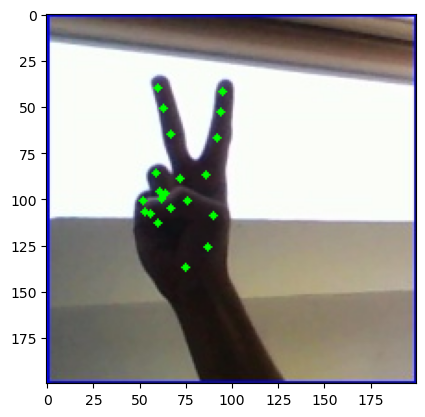

In [62]:
# example showing model inference and visualization

# pick random image in dataset
# create array of letters

letters = [letter for letter in os.listdir(DATA_DIR)]

# pick random letter
letter = np.random.choice(letters)

# pick random image
img_path = np.random.choice(os.listdir(os.path.join(DATA_DIR, letter)))

# Load image from file
mp_image = mp.Image.create_from_file(os.path.join(DATA_DIR, letter, img_path))

with HandLandmarker.create_from_options(options) as landmarker:

    results = landmarker.detect(mp_image)
    if results.hand_landmarks:
        hand_landmarks = []
        for landmark in results.hand_landmarks[0]:
            hand_landmarks.append(landmark.x)
            hand_landmarks.append(landmark.y)

        prediction = model.predict([hand_landmarks])
        print(f'Predicted number of fingers: {prediction[0]}, Actual: {classifications[letter]}')

        img = cv2.imread(os.path.join(DATA_DIR, letter, img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # draw landmarks with small radius
        for landmark in results.hand_landmarks[0]:
            cv2.circle(img, (int(landmark.x * img.shape[1]), int(landmark.y * img.shape[0])), 2, (0, 255, 0), -1)


        plt.imshow(img)
        plt.show()
    else:
        print('No hand landmarks detected')


In [60]:
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)